# Image Prediction
We want to be able to perform predictions on arbitrary image sizes, but the network has specifically been trained to process 512x512 images. Passing larger images takes up a lot of memory, so I thought that one way to get around that would be to chop up the image into 512x512 pieces, after which each piece is passed through the network and merged together afterwards. The end result is a method that works on arbitrary image sizes. This notebook is primarily for testing that this functionality works as intended.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import tensorflow as tf

from copy import deepcopy
from PIL import Image
from libs.pconv_model import PConvUnet
from libs.util import random_mask
from libs.util import get_mask

%load_ext autoreload
%autoreload 2

# SETTINGS
BATCH_SIZE = 4

Using TensorFlow backend.


# Sample Images
These are the images and masks that we will attempt to pass through the network; they are all either too small or too large in one dimension.

img_lst size: 11 | mask_lst size: 11


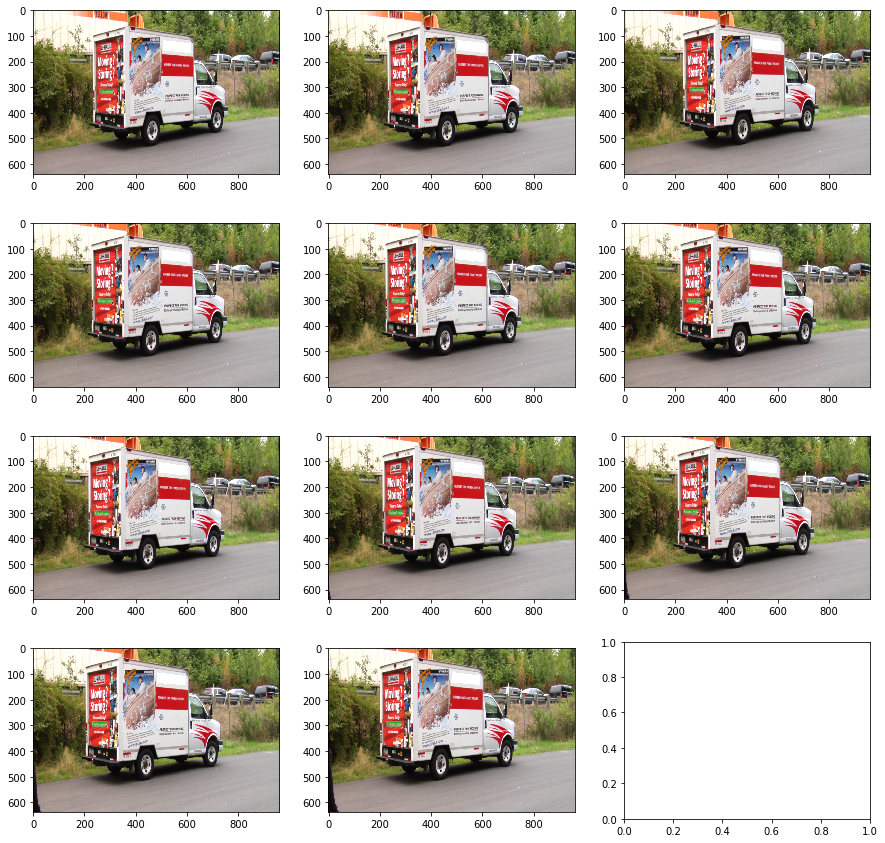

In [11]:
img_lst = []
for filename in glob.glob('data/sequences/footage/*.png'):
    im = Image.open(filename)
    img_lst.append(im)
    
mask_lst = []
for filename in glob.glob('data/sequences/mask/*.jpg'):
    mask_lst.append(filename)

_, footage_axes = plt.subplots((int)(len(img_lst)/3)+1, 3, figsize=(15, 15))

imgs, masks = [], []

# Plot images
for im, mk, ax in zip(img_lst, mask_lst, footage_axes.flatten()):
    
    # Create masked array
    im = np.array(im) / 255
    
    # mask = random_mask(*crop)
    mask = get_mask(mk)
    
    im[mask==0] = 1
    
    # Store for prediction
    imgs.append(im)
    masks.append(mask)
    
    ax.imshow(im)
    
print("img_lst size:", len(img_lst), "| mask_lst size:", len(mask_lst))

In [13]:
with tf.device('/cpu:0'):
    model = PConvUnet(weight_filepath='data/logs/')
    # model.load(r"", train_bn=False)
    model.load(r"data\logs\70_weights_2018-11-16-15-07-15.h5", train_bn=False)

In [46]:
pred = model.scan_predict((imgs[0], masks[0]))


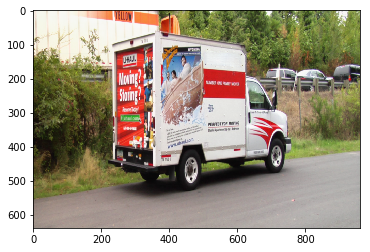

In [50]:
plt.imshow(pred)
#plt.savefig('data/sequences/prediction/test.png")
plt.imsave('data/sequences/prediction/test.png', pred) 

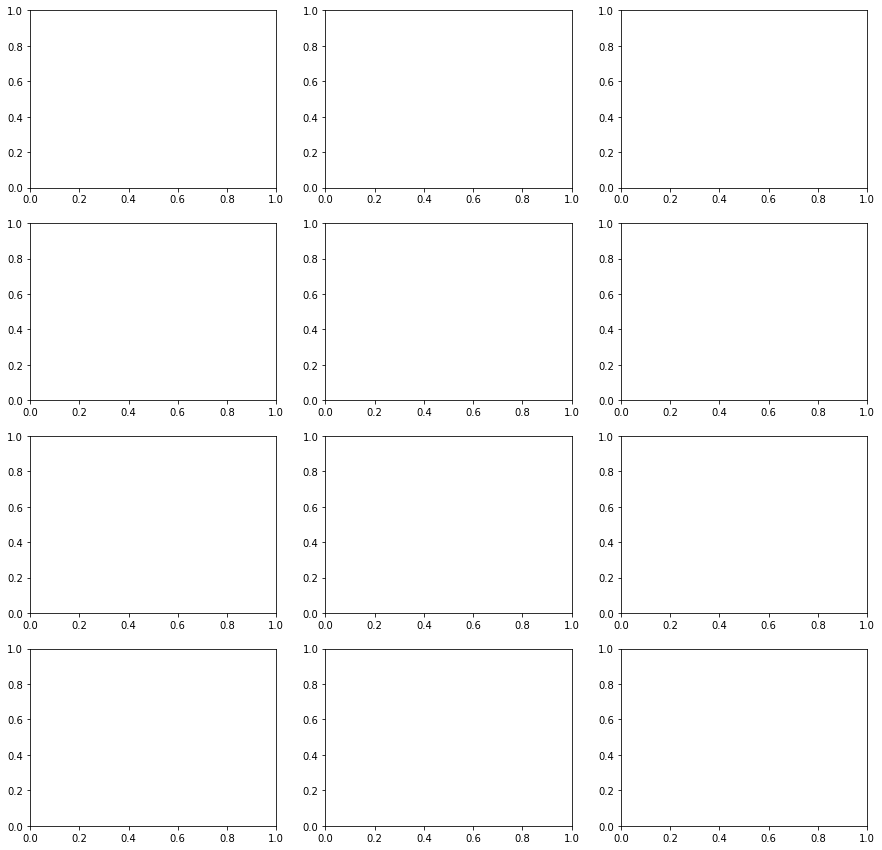

In [51]:
def plot_images(images, s=5):
    _, axes = plt.subplots(1, len(images), figsize=(s*len(images), s))
    if len(images) == 1:
        axes = [axes]
    for img, ax in zip(images, axes):
        ax.imshow(img)
    plt.show()

fig, pred_axes = plt.subplots((int)(len(img_lst)/3)+1, 3, figsize=(15, 15))

counter = 0

for im, mk, ax in zip(imgs, masks, pred_axes.flatten()):#, #pred_axes.flatten()):
    # Run prediction quickly
    pred = model.scan_predict((im, mk))
    filename = 'data/sequences/prediction/pred_%04d.jpg' % (counter)
    plt.imsave(filename, pred) 
    counter = counter +1


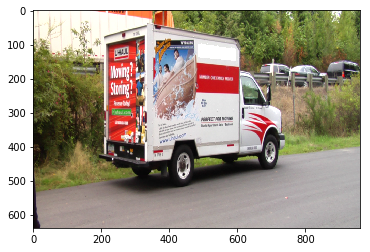

In [9]:
# SAMPLE_IMAGE = 'data/my_bike.jpg'
SAMPLE_IMAGE = 'data/uhaul_walk.0008.png'
# SAMPLE_IMAGE = 'data/uhaul_jpeg.jpg'

SAMPLE_MASK = 'data/uhaul_mask_0008.jpg'

im = Image.open(SAMPLE_IMAGE)
h, w = im.height, im.width
crops = [[h,w]]

# Lists for saving images and masks
imgs, masks = [], []

# Plot images
for crop in zip(crops):
    # Create masked array
    im = np.array(im) / 255
    
    # mask = random_mask(*crop)
    mask = get_mask(SAMPLE_MASK)
    
    im[mask==0] = 1
    
    # Store for prediction
    imgs.append(im)
    masks.append(mask)

    # Show image
    plt.imshow(im)

# Model Loading
We'll load the model trained on ImageNet

In [10]:
import tensorflow as tf
with tf.device('/cpu:0'):
    model = PConvUnet(weight_filepath='data/logs/')
    # model.load(r"", train_bn=False)
    model.load(r"data\logs\70_weights_2018-11-16-15-07-15.h5", train_bn=False)

Seems to work well. We can try plotting the reconstructed image of the last prediction

# Convenience function
To easily run predictions on an arbitrarily sized image, I implemented a `scan_predict()` method for doing all the above. As an example:

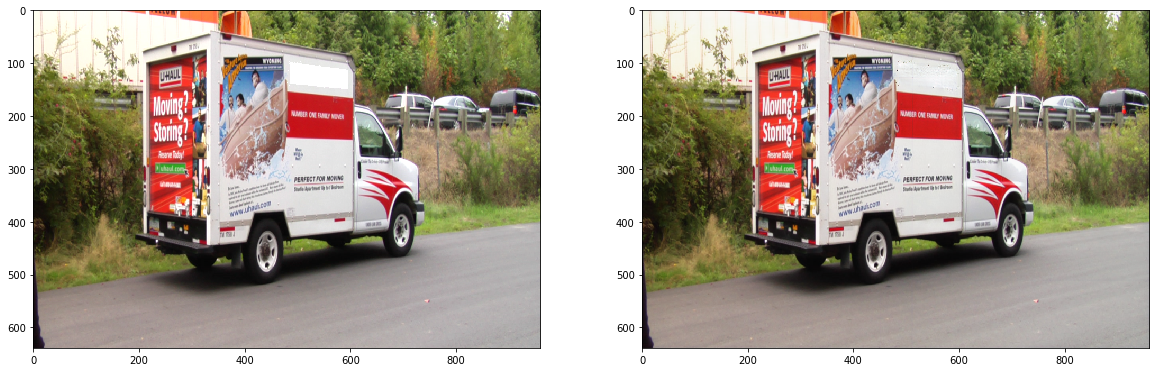

In [11]:
mask = get_mask(SAMPLE_MASK)

def plot_images(images, s=5):
    _, axes = plt.subplots(1, len(images), figsize=(s*len(images), s))
    if len(images) == 1:
        axes = [axes]
    for img, ax in zip(images, axes):
        ax.imshow(img)
    plt.show()
    

for img, mask in zip(imgs, masks):
    
# Run prediction quickly
pred = model.scan_predict((im, mask))

# Show result
plot_images([im, pred], s=10)